# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks :
    + Data augmentation: flipped images, greylevel image editing, etc. You can explore the Keras image augmentation layers https://keras.io/api/layers/preprocessing_layers/image_augmentation/
    + SGD: Changing learning rate and momentum over time.
    + Training: Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
+ To transform your solution in a Fully Convolutional Network (FCN) to make it independent of the input image size!


> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.
+ How you have implemented the FCN (including one inference example).

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
import tensorflow as tf

BASE_PATH: str = "/kaggle/input/dl-2nd-assignment"
FTRAIN = f"{BASE_PATH}/training.csv"
FTEST = f"{BASE_PATH}/test.csv"
assert os.path.isfile(FTRAIN)
assert os.path.isfile(FTEST)
# !wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
# !wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv


## Auxiliary functions

### Loading data

In [2]:
# loading data

# FLOOKUP = 'IdLookupTable.csv'

from typing import Tuple


def load(test = False, cols = None, verbose: bool = False):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    if verbose: 
        print("There are missing points:")
        print(df.count())  # prints the number of values for each column
    
    df = df.dropna()  # drop all rows that have missing values in them
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0], 96, 96), y

### Visualization

In [3]:
def plot_sample(x, y, ax: pyplot.Axes = None) -> pyplot.Axes:
    """
    Plots a single sample image with keypoints on top.   
    """
    if ax is None:
        ax = pyplot.gca()
    ax.imshow(x, cmap='gray')
    ax.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    return ax
    
    
def plot_random_sample(x_arrays, y_arrays) -> None: 
    _rand_indx = np.random.randint(x_arrays.shape[0])
    plot_sample(x_arrays[_rand_indx, :, :, :], y_arrays[_rand_indx, :])
    pyplot.show();


def plot_several_samples(x_arrays, y_arrays) -> None:
    fig, axes = pyplot.subplots(nrows=3, ncols=3, figsize=(10, 10))
    axes = axes.flatten()
    for _i in range(axes.shape[0]):
        _rand_indx = np.random.randint(x_arrays.shape[0])
        axes[_i] = plot_sample(x_arrays[_rand_indx, :, :, :], y_arrays[_rand_indx], axes[_i])
    pyplot.show();

### Data augmentation

#### Auxiliary functions for the augmentation

In [4]:
from imgaug.augmenters.blur import blur_gaussian_ 
from imgaug.augmenters.contrast import adjust_contrast_gamma


def __interchange_labels(labels: np.ndarray) -> np.ndarray:
    # for _i in range(labels.shape[0]):
    auxiliar = np.copy(labels)
    # eye center
    labels[:, [0,1]] = auxiliar[:, [2,3]]
    labels[:, [2,3]] = auxiliar[:, [0,1]]
    # eye inner corner
    labels[:, [4,5]] = auxiliar[:, [8,9]]
    labels[:, [8,9]] = auxiliar[:, [4,5]]
    # eye outer corner
    labels[:, [6,7]] = auxiliar[:, [10,11]]
    labels[:, [10,11]] = auxiliar[:, [6,7]]
    # eyebrow inner corner
    labels[:, [12,13]] = auxiliar[:, [16,17]]
    labels[:, [16,17]] = auxiliar[:, [12,13]]
    # eyebrow outer corner
    labels[:, [14,15]] = auxiliar[:, [18,19]]
    labels[:, [18,19]] = auxiliar[:, [14,15]]
    # mouth corner
    labels[:, [22,23]] = auxiliar[:, [24,25]]
    labels[:, [24,25]] = auxiliar[:, [22,23]]
    
    return labels


def __horizontal_flip(images: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    flipped_images = np.flip(np.copy(images), axis=-1)
    flipped_labels = np.copy(labels)
    # we physically flip the labels
    flipped_labels[:, 0::2] *= -1
    # and we interchange the labels index: otherwise left eye features
    # would be (correctly placed) but in the right one
    flipped_labels = __interchange_labels(flipped_labels)
    return flipped_images, flipped_labels


def __modify_saturation(images: np.ndarray, labels: np.ndarray, gamma: float = 1.75) -> Tuple[np.ndarray, np.ndarray]:
     return adjust_contrast_gamma(np.copy(images), gamma=gamma), np.copy(labels)

    
def __increase_brightness(images: np.ndarray, labels: np.ndarray, factor: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    return np.copy(images) ** factor, np.copy(labels)


def __decrease_brightness(images: np.ndarray, labels: np.ndarray, factor: float = 1.5) -> Tuple[np.ndarray, np.ndarray]:
    return __increase_brightness(images, labels, factor=factor)


def __add_gaussian_noise(images: np.ndarray, labels: np.ndarray, factor: float = 0.025) -> Tuple[np.ndarray, np.ndarray]:
    return np.stack([np.random.normal(_img, factor) for _img in np.rollaxis(np.copy(images), 0)]), np.copy(labels)

    
def __add_gaussian_blur(images: np.ndarray, labels: np.ndarray, factor: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    return np.stack([blur_gaussian_(_img, factor) for _img in np.rollaxis(np.copy(images), 0)]), np.copy(labels)


def __salt_pepper_noise_to_image(img: np.ndarray) -> np.ndarray:
    row, col = img.shape
    for _ in range(np.random.randint(row * col // 200, row * col // 160)):  # white pixels
        img[np.random.randint(row), np.random.randint(col)] = 1.
    for i in range(np.random.randint(row * col // 200, row * col // 160)):  # black pixels
        img[np.random.randint(row), np.random.randint(col)] = 0.
        
    return img


def __add_salt_pepper_noise(images: np.ndarray, labels: np.ndarray, factor: float = 0.45) -> Tuple[np.ndarray, np.ndarray]:
    return np.stack([__salt_pepper_noise_to_image(_img) for _img in np.rollaxis(np.copy(images), 0)]), np.copy(labels) 

#### Main function (however it is not used because the notebook crashes due to lack of RAM memory)

In [5]:
def perform_data_augmentation(images: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    We perform each data augmentation techinque for each sample (previously modified or not).
    In particular, we increase the sample from n up to 2^(a)*n being a the number of augmentations.
    IMPORTANT: not to add more transformations, the RAM cannot with more
    """
    transformations_to_apply = (__horizontal_flip, __increase_brightness, __decrease_brightness, 
                                __add_gaussian_blur, __add_gaussian_noise, __add_salt_pepper_noise)
    _drop_quantity = np.linspace(0.1, 0.25, num=len(transformations_to_apply))
    for _i, _transformation in enumerate(transformations_to_apply):
        # we apply the transformation to each sample (coming from raw images or other transformations)
        _trans_images, _trans_labels = _transformation(images, labels)
        images = np.concatenate([_trans_images, images], axis=0)
        labels = np.concatenate([_trans_labels, labels], axis=0)
        
        # we randomly drop a percentage of the labels
        _random_idxs = np.random.randint(x_train.shape[0], size=int(_drop_quantity[_i] * images.shape[0]))
        images, labels = np.delete(images, _random_idxs, axis=0), np.delete(labels, _random_idxs, axis=0)
    
    return images, labels

## Data pipeline: perform split and augmetation

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle

X, y = load()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)
x_train, y_train = perform_data_augmentation(x_train, y_train)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

# with the process I obtain 60k of samples, in order to handle them with ease, I drop 20k randomly
_random_idxs = np.random.randint(x_train.shape[0], size=int(x_train.shape[0] // 2.5))
x_train, y_train = np.delete(x_train, _random_idxs, axis=0), np.delete(y_train, _random_idxs, axis=0)

In [8]:
# we finally serialize not to loose the information
with open('/kaggle/working/x_train.pkl', 'wb') as empty_file:
    pickle.dump(x_train, empty_file)
with open('/kaggle/working/y_train.pkl', 'wb') as empty_file:
    pickle.dump(y_train, empty_file)

print(f"We have a total of {x_train.shape[0]} samples")

We have a total of 40294 samples


# Model set up

In [9]:
input_shape = (96, 96, 1)
output_shape = y_train.shape[1]
epochs = 150

### Losses and metrics

In [10]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

## Compiler and callbacks

In [11]:
import numpy as np
from tensorflow.keras import layers
import os
import datetime


def _get_optimizer(_type: str = 'adam', _scheduler: str = None, lr: float = 0.001):
    if _scheduler is None:
        lr_schedule = lr
    elif _scheduler == 'cosine':
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            lr, decay_steps=100000, alpha=0.0, name=None)
    elif _scheduler == 'exp':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            lr, decay_steps=100000, decay_rate=0.96, staircase=True)
    else:
        raise ValueError(f"Unrecognized decay choice: {_decay}")
    
    if _type == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=lr_schedule, beta_1=tf.Variable(0.9))  
    elif _type == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=lr_schedule, momentum=tf.Variable(0.1))
    else:
        raise KeyError(f"Unrecognized type of compiler {_type}")
    return optimizer

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", min_delta=1e-4, patience=int(0.1 * epochs),
        verbose=1, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=int(0.05) * epochs,
    verbose=1, mode="auto", min_delta=0.00005, cooldown=0, min_lr=0.0001)

## DCNN backbone

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

def get_dcnn_model(_summary: bool = False) -> keras.Sequential:
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), name='last_pool'),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Flatten(name='flatten'),
            layers.Dropout(0.25),
            layers.Dense(output_shape, activation="linear", name='output_layer'),
        ])
    if _summary:
        model.summary()

    return model


model_dccn = get_dcnn_model(_summary=True)

2022-12-01 20:23:36.253297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.254301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.596437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.597346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.598222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)       7

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.609115: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 20:23:36.876645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.877654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 20:23:36.878511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

## DCNN training

In [13]:
# %load_ext tensorboard
# %tensorboard --logdir logs
from tensorflow.keras.models import save_model

optimizer = 'adam'  # 'sgd' # _get_optimizer(_scheduler='cosine')
callbacks = [early_stopping, reduce_lr]

model_dccn.compile(loss=root_mean_squared_error, optimizer=optimizer)
history = model_dccn.fit(x_train, y_train, batch_size=128,  # 64
                    epochs=epochs, callbacks=callbacks, verbose=1, validation_data=(x_valid, y_valid))
model_name, model_dir = 'dcnn', '/kaggle/working'
save_model(model_dccn, f"{model_dir}/{model_name}.h5")

2022-12-01 20:23:42.029292: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1485398016 exceeds 10% of free system memory.
2022-12-01 20:23:43.926548: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1485398016 exceeds 10% of free system memory.
2022-12-01 20:23:45.139664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-12-01 20:23:47.965491: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


315/315 [==============================] - 40s 82ms/step - loss: 0.0789 - val_loss: 0.0664
Epoch 2/150
315/315 [==============================] - 24s 76ms/step - loss: 0.0537 - val_loss: 0.0339
Epoch 3/150
315/315 [==============================] - 24s 77ms/step - loss: 0.0320 - val_loss: 0.0286
Epoch 4/150
315/315 [==============================] - 25s 78ms/step - loss: 0.0262 - val_loss: 0.0274
Epoch 5/150
315/315 [==============================] - 25s 78ms/step - loss: 0.0229 - val_loss: 0.0268
Epoch 6/150
315/315 [==============================] - 25s 79ms/step - loss: 0.0211 - val_loss: 0.0263
Epoch 7/150
315/315 [==============================] - 25s 79ms/step - loss: 0.0196 - val_loss: 0.0269
Epoch 8/150
315/315 [==============================] - 25s 79ms/step - loss: 0.0188 - val_loss: 0.0265
Epoch 9/150
315/315 [==============================] - 25s 79ms/step - loss: 0.0178 - val_loss: 0.0261
Epoch 10/150
315/315 [==============================] - 25s 80ms/step - loss: 0.0172 

### Convergence plot

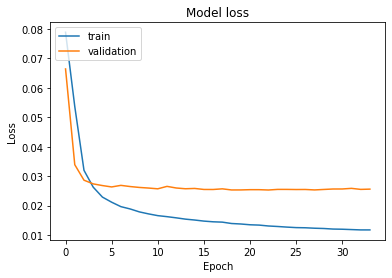

In [14]:
import matplotlib.pyplot as plt

def plot_model_loss(_hist: dict):
    # "Loss"
    plt.plot(_hist['loss'])
    plt.plot(_hist['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_model_loss(history.history);

## Model inference

In [15]:
y_hat_train = model_dccn.predict(x_train)
print("TRAIN: Mean pixel error: ", rmse_pixel(y_train, y_hat_train))
y_hat_valid = model_dccn.predict(x_valid)
print("VALIDATION: Mean pixel error: ", rmse_pixel(y_valid, y_hat_valid))
y_hat_test = model_dccn.predict(x_test)
print("TEST: Mean pixel error: ", rmse_pixel(y_test, y_hat_test))

2022-12-01 20:38:14.388151: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1485398016 exceeds 10% of free system memory.
2022-12-01 20:38:16.360904: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1485398016 exceeds 10% of free system memory.


TRAIN: Mean pixel error:  0.48577362
VALIDATION: Mean pixel error:  1.2153924
TEST: Mean pixel error:  1.2993714


## Results visualization

### Ground-truth labels

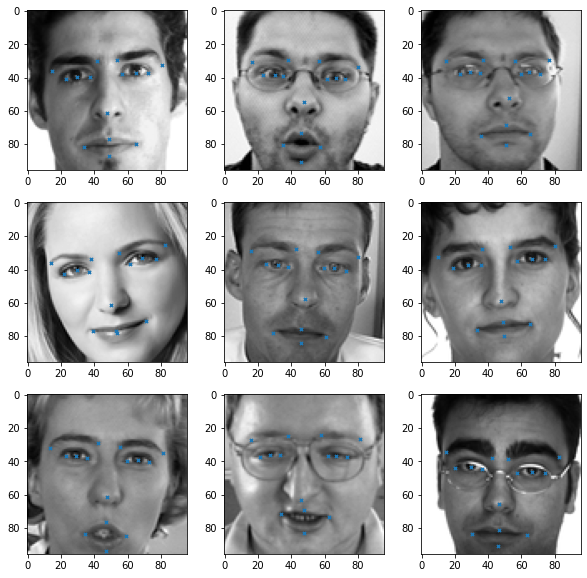

In [16]:
plot_several_samples(x_test, y_test)

### Predicted labels

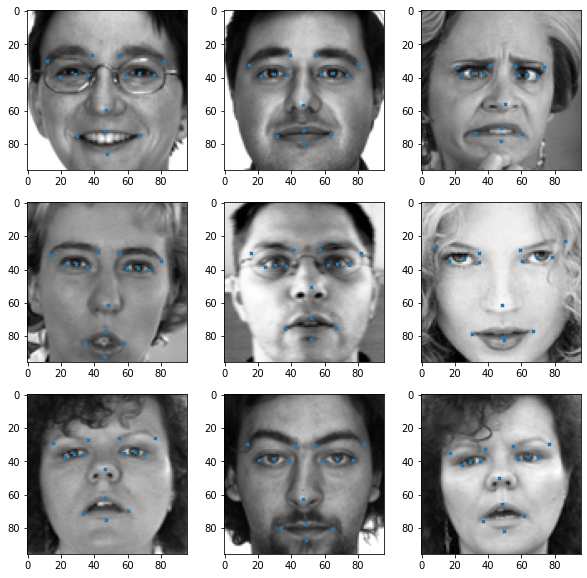

In [17]:
plot_several_samples(x_test, y_hat_test)

## Extra: CNN-XGB to outperform a simple Dense regressor

In [30]:
from xgboost import XGBRegressor
from tensorflow.keras.models import load_model, Model

# model = load_model(f"{model_dir}/{model_name}.h5", custom_objects={'root_mean_squared_error': root_mean_squared_error}).get_layer('flatten').output.eval()

class XGBFCN:
    def __init__(self):
        self.xgbmodel = XGBRegressor(objective='reg:squarederror', use_label_encoder=False, eval_metric='rmse')
        self.dcnn = Model(
            inputs=model_dccn.input, 
            outputs=model_dccn.output)
        self.dcnn.trainable = False  # freeze the pretrained weights
        
    def fit(self, x_train: np.ndarray, y_train: np.ndarray, x_valid: np.ndarray, y_valid: np.ndarray) -> None:
        self.xgbmodel.fit(self.dcnn.predict(x_train), y_train, eval_set=[(self.dcnn.predict(x_valid), y_valid)], verbose=1)
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.xgbmodel.predict(self.dcnn.predict(x))
    
    def score(self, x: np.ndarray, y: np.ndarray):
        return root_mean_squared_error(y, self.predict(x))

## Model inference

In [31]:
model_xgb = XGBFCN()
model_xgb.fit(x_train, y_train, x_valid, y_valid)

[0]	validation_0-rmse:0.44979
[1]	validation_0-rmse:0.31560
[2]	validation_0-rmse:0.22184
[3]	validation_0-rmse:0.15652
[4]	validation_0-rmse:0.11121
[5]	validation_0-rmse:0.08008
[6]	validation_0-rmse:0.05904
[7]	validation_0-rmse:0.04523
[8]	validation_0-rmse:0.03657
[9]	validation_0-rmse:0.03141
[10]	validation_0-rmse:0.02852
[11]	validation_0-rmse:0.02696
[12]	validation_0-rmse:0.02615
[13]	validation_0-rmse:0.02572
[14]	validation_0-rmse:0.02552
[15]	validation_0-rmse:0.02541
[16]	validation_0-rmse:0.02535
[17]	validation_0-rmse:0.02532
[18]	validation_0-rmse:0.02530
[19]	validation_0-rmse:0.02529
[20]	validation_0-rmse:0.02530
[21]	validation_0-rmse:0.02530
[22]	validation_0-rmse:0.02529
[23]	validation_0-rmse:0.02530
[24]	validation_0-rmse:0.02531
[25]	validation_0-rmse:0.02531
[26]	validation_0-rmse:0.02531
[27]	validation_0-rmse:0.02531
[28]	validation_0-rmse:0.02531
[29]	validation_0-rmse:0.02531
[30]	validation_0-rmse:0.02532
[31]	validation_0-rmse:0.02532
[32]	validation_0-

In [32]:
print("TRAIN: Mean pixel error: ", rmse_pixel(y_train, model_xgb.predict(x_train)))
y_hat_valid_xgb = model_xgb.predict(x_valid)
print("VALIDATION: Mean pixel error: ", rmse_pixel(y_valid, model_xgb.predict(x_valid)))
y_hat_test_xgb = model_xgb.predict(x_test)
print("TEST: Mean pixel error: ", rmse_pixel(y_test, model_xgb.predict(x_test)))

TRAIN: Mean pixel error:  0.19999866
VALIDATION: Mean pixel error:  1.2212002
TEST: Mean pixel error:  1.2932633


# Fully Convolutional Network (FCN)

#### We keep the same backbone than 

In [20]:
def get_fcn_model(_summary: bool = False) -> keras.Sequential:
    model = keras.Sequential(
        [
            keras.Input(shape=(None, None, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2), name='last_pool'),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Dropout(0.25),
            layers.Conv2D(output_shape, kernel_size=(3, 3), activation="linear", name='output_layer'),
            layers.GlobalAveragePooling2D(),
        ])
    if _summary:
        model.summary()

    return model


model_fcn = get_fcn_model(_summary=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, None, None, 32)    320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 64)    18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 128)  

### Model training

In [21]:
optimizer = 'adam'  # 'sgd' # _get_optimizer(_scheduler='cosine')
callbacks = [early_stopping, reduce_lr]
model_fcn.compile(loss=root_mean_squared_error, optimizer=optimizer)
history = model_fcn.fit(x_train, y_train, batch_size=64,  # 64
                    epochs=epochs, callbacks=callbacks, verbose=1, validation_data=(x_valid, y_valid))  # validation_split=0.1)
model_name, model_dir = 'fcn', '/kaggle/working'
save_model(model_fcn, f"{model_dir}/{model_name}.h5")

2022-12-01 20:38:31.550389: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1485398016 exceeds 10% of free system memory.


Epoch 1/150
630/630 [==============================] - 28s 41ms/step - loss: 0.0742 - val_loss: 0.0510
Epoch 2/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0402 - val_loss: 0.0313
Epoch 3/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0289 - val_loss: 0.0284
Epoch 4/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0246 - val_loss: 0.0268
Epoch 5/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0221 - val_loss: 0.0267
Epoch 6/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0203 - val_loss: 0.0262
Epoch 7/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0191 - val_loss: 0.0258
Epoch 8/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0181 - val_loss: 0.0257
Epoch 9/150
630/630 [==============================] - 25s 40ms/step - loss: 0.0173 - val_loss: 0.0261
Epoch 10/150
630/630 [==============================] - 25s 40ms/step - l

### Convergence plot

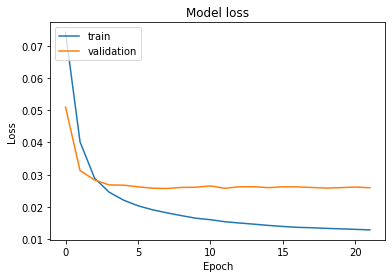

In [22]:
def plot_model_loss(_hist: dict):
    # "Loss"
    plt.plot(_hist['loss'])
    plt.plot(_hist['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_model_loss(history.history);

### Model inference

In [23]:
y_hat_train_fcn = model_fcn.predict(x_train)
print("TRAIN: Mean pixel error: ", rmse_pixel(y_train, y_hat_train_fcn))
y_hat_valid_fcn = model_fcn.predict(x_valid)
print("VALIDATION: Mean pixel error: ", rmse_pixel(y_valid, y_hat_valid_fcn))
y_hat_test_fcn = model_fcn.predict(x_test)
print("TEST: Mean pixel error: ", rmse_pixel(y_test, y_hat_test_fcn))

TRAIN: Mean pixel error:  0.7266772
VALIDATION: Mean pixel error:  1.2430251
TEST: Mean pixel error:  1.32992


## Results visualization

### Ground-truth labels

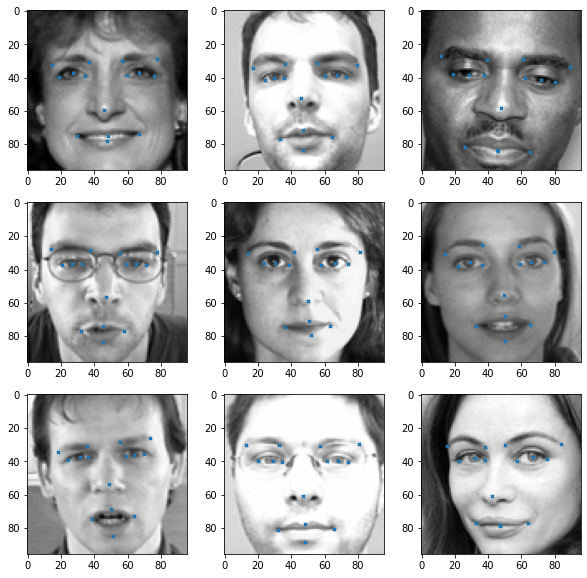

In [24]:
plot_several_samples(x_test, y_test)

#### Predicted labels

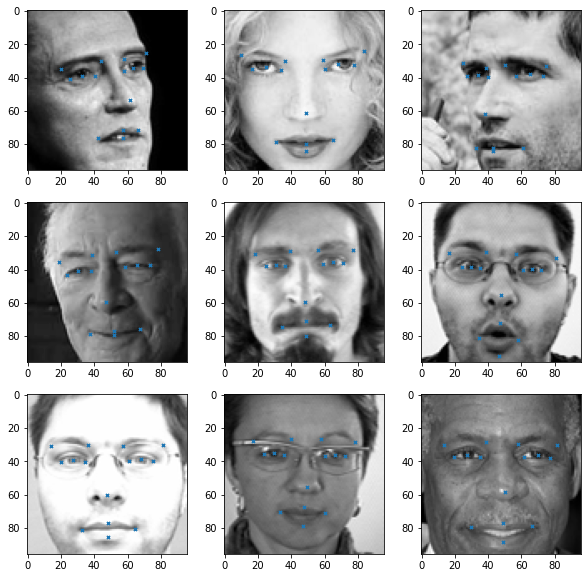

In [25]:
plot_several_samples(x_test, y_hat_test_fcn)

# Reporting

Please, report the results of your experiments in this cell.

**Answer**: the outputs of this notebook already contained the outputs I obtained, however this can also be consulted at Kaggle (where I developed it and leveraged their GPUs) in this [link](https://www.kaggle.com/gcastro98hack/dl-2nd-assignment-gerard-castro-castillo). 

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error I obtained for the DCNN was of: 
- Training set:  0.48577362
- Validation set:  1.2153924
- **Test set:  1.2993714**

If I leverage a XGB regressor instead of the linear one coming from the last dense layer, the model was slightly outperformed (in the test set) with an skill of:
- Training set: 0.19999866
- Validation set: 1.2212002
- Test set:  1.2932633

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: On the one hand, I used a x3 (2x Conv + MaxPool) backbone (really common in the literature), always with kernel size (3, 3) and an increasing number of neurons 32, 64, 256 (with an extra layer of 128 between pooling and convolution, actually, as exception). Finally, after the last convolution, a flatten is made and connected to the Dense output layer.

On the other hand, below I list some of the well-known DL techniques I leveraged to improve my result:
- _Data augmentation_: for sure the most important step for this problem in which there is a clear lack of data. It is needless to remind these transformations have just to be applied to the training set, leaving untouched the test and validation ones. In my case, I applied them exhausting every possible combination of the training sample. With that I obtained almost 60k samples (and during the process I was dropping some indexes to avoid much more samples), an almost 50% of which were randomly dropped to ease RAM memory. In particular, the data augmentation techniques that worked the best were:
    - ``Horizontal flip``: vertical flip and rotations were discarded due to the fact the faces in the raw dataframe are naturally oriented (not inverted or rotated). This is without doubt the most useful (in terms of achieved skill) transformation, but also the one that needs more care (when properly flipping the labels)
    - ``Random variations``: of brightness & contrast (and saturation if the images were in color)
    - ``Blur effect``: also the images were blurred to mock up images where the focus was not proper
    - ``Noise adding``: Gaussian noise worked better than the so-called salt & pepper noise
- _Dropout_: as far as I am concerned, I experienced that adding Dropout in DCNN or FCN (even in the last layer) is not the best way to avoid overfitting. Instead, if used incorrectly, it can lower the training speed. In order to regularize the network and avoid overfitting I simplified the complexity of the network once I detected overfitting by reducing the kernel size of the convolutional layers or the amount of neurons per layer. Another option is to leverage another MaxPooling if necessary. Apart from that, of course, I used early stopping. However, I did use some controlled Dropout (after Flatten) because after all this I was still overfitting a little bit.
- _Learning rate scheduler_: I tried several schedulers:
    - By epochs: such as the Exponential or the Cosine decays
    - By the loss: through the ``ReduceLROnPlateau``. This was the one it worked better
- At first I trained 4 models for each kind of feature; however, the skill improvement was not worth the x4 time-consuming process. The process and set up, nevertheless, is extremely simple: with 4 with the same backbone and just changing the output shape. For instance, if a model specialist for the eyes was built the output shape would be 12, 8 for the eyebrows, 2 for the nose and 8 for the mouth, for instance.
- ``Extra``: Instead of the former, I implemented a mix of XGB with CNN that outperforms a single DCNN (since the last layer is not a simple linear regressor anymore)

## What is the architecture of your FCN?

**Answer**: I used the same backbone than the DCNN. However in the case of a FCN, instead of a Flatten layer, a last convolutional layer **with the output shape as the number of neurons** and **linear activation** is added before the last layer, which is no other than a GlobalAveragePooling. This ensures the output is exactly the needed one without need of any constraint in the input size.

As opposed to my implementation, there also exists a possibility in which no GlobalAveragePooling is used; however, it requires a strong constraint to the size of the new passed images: they have to multiple of the kernel size (``2`` in my case). It would consist in applying the flatten directly after the last convolution and having a variable-size number of outputs (but multiple of ``30``). Then, a sliding window could be applied finally to detect which of the ``30 * n`` outputs actually corresponds to the facial keypoints. This, however, is not as useful as my implementation for the strong constraint in image shape.

### Insert one of the test images in a larger image and show the detection result. The size of the face cannor change!

Below I plot several images where random padding were performed to harness the FCN in work which, as can be seen, works for any kind of size.





#### Auxiliary function to pad images and randomly plot padded images

In [26]:
IMG_SIZE: int = 96

def _pad_images(images: np.ndarray, labels: np.ndarray, n_rows: int = 20, n_cols: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """
    It is assumed an array of images is passed, i.e. shape (n_imgs, IMG_SIZE, IMG_SIZE, 1).
    """
    new_images: np.ndarray = np.pad(images, ((0, 0), (n_rows, n_rows), (n_cols, n_cols), (0, 0)))
    new_labels: np.ndarray = np.zeros(labels.shape)
    for _i in range(new_labels.shape[0]):
        for _j in range(new_labels.shape[1]):
            # print(labels[_i, _j])
            new_labels[_i, _j] = labels[_i, _j] + n_cols / (IMG_SIZE / 2) if _j % 2 == 0 else labels[_i, _j] + n_rows / (IMG_SIZE / 2)
    return new_images, new_labels


def _randomly_pad_images(images: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    fig, axes = pyplot.subplots(nrows=3, ncols=3, figsize=(10, 10))
    axes = axes.flatten()
    for _i in range(axes.shape[0]):
        _rand_indx, _n_pad = np.random.randint(images.shape[0]), np.random.randint(10, 101)
        _pad_img, _pad_label = _pad_images(np.expand_dims(images[_rand_indx, :, :, :], 0), np.expand_dims(labels[_rand_indx, :], 0), n_rows=_n_pad, n_cols=_n_pad)
        axes[_i] = plot_sample(_pad_img[0, :, :, :], _pad_label[0, :], ax=axes[_i])
    fig.show()

### Harnessing the power of the FCN 

#### Ground-truth labels (padded)

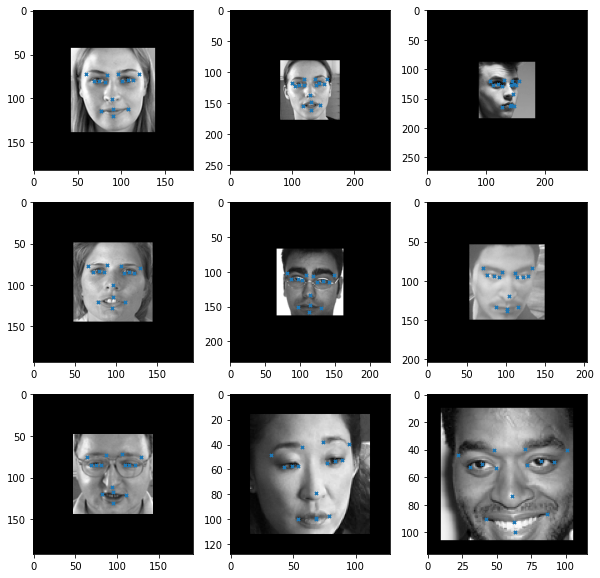

In [27]:
_randomly_pad_images(x_test, y_test)

#### Predicted labels (padded)

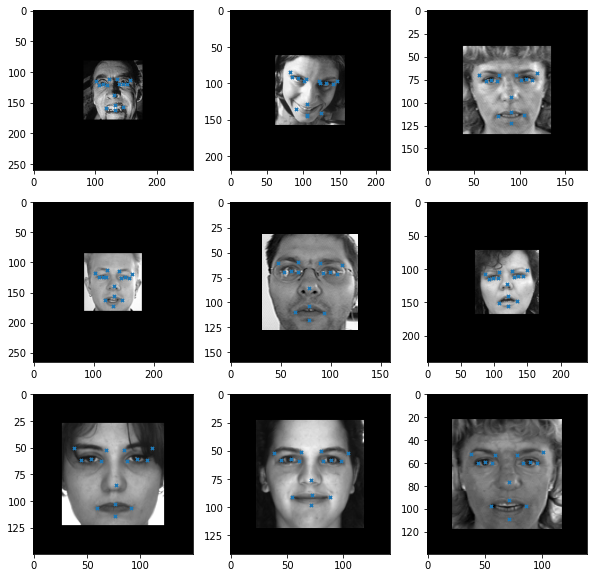

In [28]:
_randomly_pad_images(x_test, y_hat_test_fcn)